In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt

**PART -1**

In [3]:
train = read_csv('/content/drive/MyDrive/Civil-7630/ML_HomeWork/fashion-mnist_train.csv')
test = read_csv('/content/drive/MyDrive/Civil-7630/ML_HomeWork/fashion-mnist_test.csv')

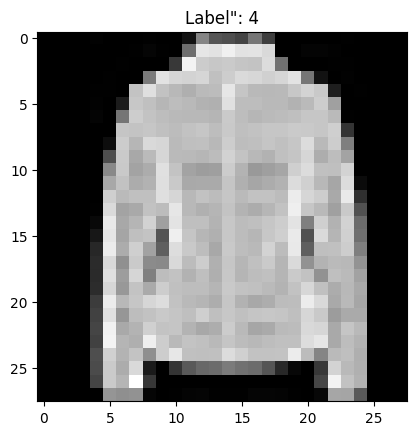

In [4]:
#Example of the output variable

instance = 25
plt.imshow(np.reshape(np.array(train.iloc[instance,1:]), (-1,28)), cmap = 'gray')
plt.title('Label": %i' %train.iloc[instance, 0])
plt.show()

In [5]:
print(train.shape)
print(test.shape)

(60000, 785)
(10000, 785)


In [6]:
#In total 785 columns, the first column is the label of each image

X_train = train.drop(columns=train.columns[0], axis = 1)
Y_train = train[train.columns[0]]

X_test = test.drop(columns=test.columns[0], axis = 1)
Y_test  = test[test.columns[0]]

In [7]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


**PART-2 **(Scale the Data)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

In [10]:
# Fit SVD with the maximum number of components once
max_n_components = X_train.shape[1] - 1  # Maximum possible components
svd = TruncatedSVD(n_components=max_n_components, random_state=42)
svd.fit(X_train)

# Calculate the cumulative sum of explained variance ratios
cumulative_variance = svd.explained_variance_ratio_.cumsum()

# Find the number of components that explain at least 90% of the variance
num_components_90_variance = next(i for i, total_variance in enumerate(cumulative_variance) if total_variance >= 0.9) + 1

# Create the list of explained variances up to the number that explains at least 90% of the variance
variance_list = cumulative_variance[:num_components_90_variance].tolist()


print(f"Number of components that explain at least 90% of variance: {num_components_90_variance}")


Number of components that explain at least 90% of variance: 84


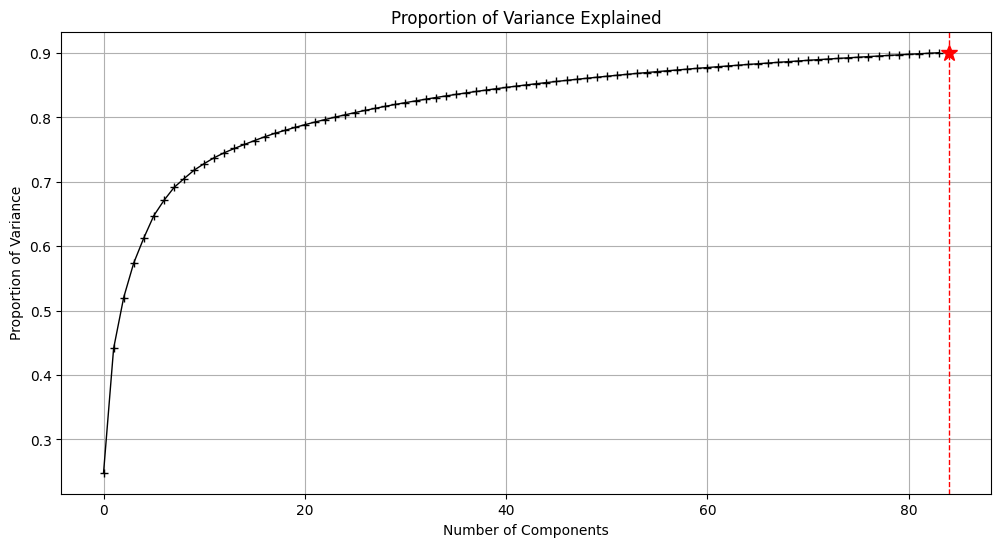

In [11]:
import matplotlib.pyplot as plt

# Using the variance_list
plt.figure(figsize=(12, 6))
plt.plot(variance_list, marker='+', color='black', linewidth=1)

# num_components_90_variance is the point at which 90% of the variance is explained
plt.axvline(x=num_components_90_variance, color='r', linestyle='--', linewidth=1)
plt.plot(num_components_90_variance, variance_list[num_components_90_variance-1], 'r*', markersize=12)  # x=num_components_90_variance because the count starts from 0

plt.title("Proportion of Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance")
plt.grid(True)
# plt.savefig('Proportion of Variance Explained.png')
plt.show()


**PART 3**

In [12]:
# We are choosing the value of n_component that gave us 90% of variance
n_components = num_components_90_variance
print("Selected n_component: ", n_components, ". It's variance ratio: ", variance_list[n_components - 1])

# Initialize and fit-transform SVD with the selected number of components
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_train_transformed = svd.fit_transform(X_train)

# Transform the test data using the already fitted SVD
X_test_transformed = svd.transform(X_test)

# Output the shape of the transformed data
print("Transformed X_train shape:", X_train_transformed.shape)
print("Transformed X_test shape:", X_test_transformed.shape)


Selected n_component:  84 . It's variance ratio:  0.9003967961014389
Transformed X_train shape: (60000, 84)
Transformed X_test shape: (10000, 84)


In [13]:
#Logistic Regression on the original dataset
from sklearn.linear_model import SGDClassifier

 #creating validation for hypertuning learning rate
XX_train, XX_val, YY_train, YY_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

scores = []
learning_rates = []
initial_lrate = 0.01
for i in tqdm(range(10)):
    lr = initial_lrate * (1 / (1 + 0.01 * i))  #tying with different lr
    LogR =  SGDClassifier(random_state=0, alpha = lr, loss='log_loss').fit(XX_train, YY_train)
    scores.append(LogR.score(XX_val, YY_val))
    learning_rates.append(lr)

100%|██████████| 10/10 [01:53<00:00, 11.33s/it]


In [14]:
a = learning_rates[scores.index(max(scores))]
print("Best value of learning rate: ", a)

#now on test data
LR =  SGDClassifier(random_state=0, alpha = learning_rates[scores.index(max(scores))], loss='log_loss').fit(X_train, Y_train)
print("Accuracy of Logistic Regression on the original dataset: ", round(LR.score(X_test, Y_test)*100,4))

Best value of learning rate:  0.009174311926605503
Accuracy of Logistic Regression on the original dataset:  81.87


In [15]:
#Logistic Regression on the reduced dataset
from sklearn.linear_model import SGDClassifier
LR =  SGDClassifier(alpha = 0.001, loss='log_loss').fit(X_train_transformed, Y_train)
print("Accuracy of Logistic Regression on the reduced dataset: ", round(LR.score(X_test_transformed, Y_test)*100,4))

Accuracy of Logistic Regression on the reduced dataset:  82.7


In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Define the k-values ahead of time
k_values = [1, 7, 18, int(np.sqrt(len(X_train)))]

# Precompute the accuracy for each k using cross-validation
scores = {}
for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(neigh, X_train, Y_train, cv=4, scoring='accuracy')
    scores[k] = np.mean(score)

# Find the k with the highest average score
best_k = max(scores, key=scores.get)

# Train and test using the best k-value
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train, Y_train)
y_pred = neigh.predict(X_test)

# If you need the accuracy for the test set:
test_accuracy = accuracy_score(Y_test, y_pred)


In [17]:
print("Accuracy of KNN on the original dataset: ", round(accuracy_score(Y_test,y_pred)*100,4))

Accuracy of KNN on the original dataset:  85.6


In [19]:
from sklearn.metrics import accuracy_score



# Calculate average cross-validation score for each k-value
scores = {k: np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=k),
                                      X_train_transformed, Y_train, cv=4, scoring='accuracy'))
          for k in k_values}

# Find the best k-value with the highest average score
best_k = max(scores, key=scores.get)

# Train and test using the best k-value on the reduced dataset
neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(X_train_transformed, Y_train)
y_pred = neigh.predict(X_test_transformed)

# Calculate and print the accuracy
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy of KNN on the reduced dataset: ", round(accuracy * 100, 4))


Accuracy of KNN on the reduced dataset:  86.79


In [20]:
#Naive Bayes on the original dataset

from sklearn.naive_bayes import GaussianNB
X_train = X_train*255.0
X_test = X_test*255.0

svd = TruncatedSVD(n_components=500)

X_train_transformed = svd.fit_transform(X_train)

X_test_transformed = svd.transform(X_test)

gnb = GaussianNB(var_smoothing = 0.05)
y_pred = gnb.fit(X_train, Y_train).predict(X_test)
print("Accuracy of Naive Bayes on the original dataset: ", round(accuracy_score(Y_test,y_pred)*100,4))

Accuracy of Naive Bayes on the original dataset:  67.82


In [21]:
#Naive Bayes on the reduced dataset
gnb = GaussianNB(var_smoothing = 0.05)
y_pred = gnb.fit(X_train_transformed, Y_train).predict(X_test_transformed)
print("Accuracy of Naive Bayes on the reduced dataset: ", round(accuracy_score(Y_test,y_pred)*100,4))

Accuracy of Naive Bayes on the reduced dataset:  69.64
